# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi wikipedia. 
Outline of the exercise:
* Dataset preparation
* Preprocessing (25 Points) 
* Exploration (20 Points) 
* TF-IDF + Search (55 Points)

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Section 0: Please enter your name below
# Name: Mohammad Amin Rami
# Student Number: 98101588

# Section 1: Dataset preparation

This section of notebook contains only shell commands. You don't need to completely understand each command or change anything.

Please run all the paragraphs sequentially.

In [1]:
 #! sudo apt-get -y install wget git

### Download the dump

In [2]:
#! wget --no-check-certificate -P . https://dumps.wikimedia.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2

## Extract the dump (this may take a few minutes)

In [3]:
#! bzip2 -d fawiki-latest-pages-articles-multistream.xml.bz2

## Clone git project for converting wikipedia xml dump to json

In [4]:
#! pip install wikiextractor

## Run the script to convert xml to json (this might take around 30 minutes)

In [5]:
#! python3 -m wikiextractor.WikiExtractor --json fawiki-latest-pages-articles-multistream.xml

## Ensure output files exist

In [6]:
#! ls text/*/*

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [7]:
#! pip install pyspark

In [8]:
from pyspark.sql import SparkSession
import re
from itertools import chain
from operator import add
import matplotlib.pyplot as plt
import math
from functools import partial

spark = SparkSession \
    .builder \
    .appName("MDA_2021") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

22/12/05 03:06:10 WARN Utils: Your hostname, MohammadAmin-VivoBook resolves to a loopback address: 127.0.1.1; using 192.168.122.1 instead (on interface virbr0)
22/12/05 03:06:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/05 03:06:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading the data

In [9]:
articles_rdd = sc.textFile("text/*/*")
articles_rdd.take(1)

['{"id": "2", "revid": "23528", "url": "https://fa.wikipedia.org/wiki?curid=2", "title": "\\u0635\\u0641\\u062d\\u0647\\u0654 \\u0627\\u0635\\u0644\\u06cc", "text": "&lt;templatestyles src=\\"\\u0635\\u0641\\u062d\\u0647 \\u0627\\u0635\\u0644\\u06cc/styles.css\\"/&gt;\\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n \\n\\u0627\\u0645\\u0631\\u0648\\u0632: \\u060c \\u0645\\u06cc\\u0644\\u0627\\u062f\\u06cc \\u0628\\u0631\\u0627\\u0628\\u0631 \\u0647\\u062c\\u0631\\u06cc \\u062e\\u0648\\u0631\\u0634\\u06cc\\u062f\\u06cc \\u0648 (UTC)\\n \\n \\n \\n \\n \' \\u2013 \'\\n \\n \\n \\n \\n \\n \\n __NOEDITSECTION__"}']

# Section 2: Preprocessing (25 Points)

In this section we will remove useless part (for example /n and /u200c and ...) also find and remove stop words and remove the words with a low count in the corpus

In [10]:
import json

def clean_page(page):
    
    replacements = {i: ' ' for i in chain(range(33, 64), range(123, 128), range(0, 32), range(91, 97))}
    replacements.update({ord('\n'): ' ',  ord('\u200c'): ' ', ord('\u200e'): ' ',
        ord('\u200d'): ' ', ord('–'): ' ', ord('_'): ' ', ord('،'): ' ', ord('.'): ' ',
        ord('•'): ' ',
    })
    
    page['text'] = re.sub(' {2,}', ' ', page['text'].translate(replacements)).strip()
    page['title'] = re.sub(' {2,}', ' ', page['title'].translate(replacements)).strip()
    return page

def extract_word(page):
    text = page['title'] + ' ' + page['text']
    return text.strip().split(' ')

articles_rdd = articles_rdd.map(json.loads).filter(lambda x: len(x['text']) > 0 )
cleansed_articles_rdd = articles_rdd.map(clean_page)
words_rdd = cleansed_articles_rdd.flatMap(extract_word)
words_count_rdd = words_rdd.map(lambda x:(x, 1)).reduceByKey(add)
top_100 = words_count_rdd.sortBy(lambda x: x[1], ascending=False).take(100)
top_100

[('در', 5082982),
 ('و', 4559153),
 ('به', 3422348),
 ('از', 2946374),
 ('است', 2647560),
 ('که', 2219670),
 ('می', 2066123),
 ('این', 1572917),
 ('را', 1428410),
 ('های', 1361211),
 ('با', 1163777),
 ('یک', 987426),
 ('آن', 871677),
 ('شده', 865550),
 ('سال', 832346),
 ('ها', 717010),
 ('شد', 690994),
 ('بود', 622928),
 ('برای', 620724),
 ('کرد', 539514),
 ('او', 515650),
 ('شود', 486181),
 ('دارد', 432803),
 ('ای', 408867),
 ('خود', 368869),
 ('بر', 365037),
 ('تا', 360684),
 ('یا', 346544),
 ('ایران', 339031),
 ('کند', 325825),
 ('واقع', 319517),
 ('وی', 297365),
 ('عنوان', 292540),
 ('نام', 283236),
 ('فوتبال', 276534),
 ('جمعیت', 275758),
 ('قرار', 273031),
 ('نیز', 260348),
 ('باشد', 250825),
 ('کرده', 239593),
 ('نفر', 237581),
 ('دو', 233996),
 ('پس', 230377),
 ('فیلم', 230280),
 ('بازی', 215451),
 ('باشگاه', 212172),
 ('استفاده', 207047),
 ('بوده', 206658),
 ('یکی', 206148),
 ('توسط', 204804),
 ('شهر', 203862),
 ('اهل', 200696),
 ('شهرستان', 190637),
 ('بخش', 187500),
 ('هم', 

In [11]:
stopwords = [
 'در',
 'نمی',
 'در',
 'و',
 'به',
 'از',
 'است',
 'که',
 'می',
 'این',
 'را',
 'های',
 'با',
 'یک',
 'آن',
 'شده',
 'ها',
 'شد',
 'بود',
 'برای',
 'کرد',
 'او',
 'شود',
 'ای',
 'دارد',
 'بر',
 'تا',
 'یا',
 'کند',
 'وی',
 'نیز',
 'باشد',
 'کرده',
 'دو',
 'پس',
 'بوده',
 'یکی',
 'هم',
 'همچنین',
 'بین',
 'دیگر',
 'اس',
 'اما',
 'هایی',
 'اند',
 '؛',
 'کنند',
 'هر',
 'هستند',
 'داد',
 'داشته',
 'داشت',
 'داده',
 'دهد',
 'شوند',
 'کردند',
 '',
]

def replace_stop_words(page):
    for stopword in stopwords:
        page['title'] = re.sub(f' {stopword} ', ' ', page['title'])
        page['title'] = re.sub(fr' {stopword}$', ' ', page['title'])
        page['text'] = re.sub(f' {stopword} ', ' ', page['text'])
        page['text'] = re.sub(fr' {stopword}$', ' ', page['text'])
    return page

articles_without_stopwords_rdd = cleansed_articles_rdd.map(replace_stop_words)

MIN_COUNT = 20
uncommon_words = words_count_rdd.filter(lambda x: x[1] < MIN_COUNT).sortBy(lambda x: x[1]).take(100)

def replace_uncommon(page):
    for word in uncommon_words:
        page['title'] = re.sub(f' {word} ', ' ', page['title'])
        page['title'] = re.sub(fr' {word}$', ' ', page['title'])
        page['text'] = re.sub(f' {word} ', ' ', page['text'])
        page['text'] = re.sub(fr' {word}$', ' ', page['text'])
    return page

articles_cleaned_rdd = articles_without_stopwords_rdd.map(replace_uncommon)

# Section 3: Exploration (20 Points)
Please answer the following questions regarding the dataset:
* How many unique 3-Letter words remain after the cleaning procedure?
* What are the top 20 most common English trigrams in the corpus?
* Plot a distribution from document lengths using appropriate bin sizes with 100 bins
* What are the titles and urls of the 5 longest articles? 
* How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]

In [12]:
cleaned_words_rdd =  words_count_rdd.filter(lambda x: (x[0] not in stopwords) and (x[0] not in uncommon_words))
three_letter_words = cleaned_words_rdd.filter(lambda x: len(x[0]) == 3).sortBy(lambda x:x[1], ascending=False)
three_letter_words_count = three_letter_words.count()
print(f'number of three letter words: {three_letter_words_count}')

number of three letter words: 41579


In [13]:
def word_is_english(example):
    return bool(re.compile(r"^[a-zA-Z]*$").match(example[0]))

top_english_words = three_letter_words.filter(word_is_english).sortBy(lambda x: x[1], ascending=False)
print('most common three letter English words')
top_english_words.take(20)

most common three letter English words


[('The', 10114),
 ('the', 9211),
 ('amp', 8271),
 ('and', 7048),
 ('org', 6816),
 ('php', 3758),
 ('mol', 3656),
 ('www', 3646),
 ('com', 3476),
 ('for', 2906),
 ('DNA', 2186),
 ('web', 1751),
 ('ref', 1637),
 ('int', 1615),
 ('New', 1537),
 ('end', 1533),
 ('bdi', 1222),
 ('III', 1158),
 ('San', 1152),
 ('new', 865)]

In [14]:
article_lengh_rdd = articles_cleaned_rdd.map(lambda x: (x, len(x['text'])))

Text(0.5, 0, 'length')

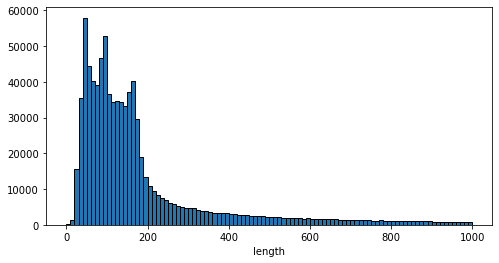

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(article_lengh_rdd.values().collect(), bins=100, range=(0, 1000), edgecolor='black')
ax.set_xlabel('length')

In [16]:
long_articles = article_lengh_rdd.sortBy(lambda x: x[1], ascending=False)
for article in long_articles.take(5):
    print(f"title: {article[0]['title']}")
    print(f"url: {article[0]['url']}")
    print(f"length: {article[1]}")
    print('='*30)

title: نادرشاه
url: https://fa.wikipedia.org/wiki?curid=10787
length: 101772
title: ایران
url: https://fa.wikipedia.org/wiki?curid=163930
length: 89892
title: نبرد اسمولنسک
url: https://fa.wikipedia.org/wiki?curid=2322946
length: 88049
title: جمهوری وایمار
url: https://fa.wikipedia.org/wiki?curid=26519
length: 84469
title: نبرد مسکو
url: https://fa.wikipedia.org/wiki?curid=1501875
length: 84277


In [17]:
words = ['سیاست', 'تاریخ', 'قانون', 'اقتصاد', 'مهندسی', 'پزشکی']
counts = []

for word in words:
    counts.append(articles_cleaned_rdd.filter(lambda x: word in x['text']).count())

article_count = articles_cleaned_rdd.count()
for i, count in enumerate(counts):
    print(f'{words[i]}:      {count}      {round(count/article_count*100 ,2)}%')

سیاست:      25071      2.68%
تاریخ:      99011      10.58%
قانون:      19969      2.13%
اقتصاد:      16900      1.81%
مهندسی:      7737      0.83%
پزشکی:      11118      1.19%


# Section 4: TF-IDF + Searching (55 Points)

In [18]:
def words_in_document(document):
    words = set((document['text'] + " " + document['title']).strip().split(' '))
    return [(word, 1) for word in words]

word_df_rdd = articles_cleaned_rdd.flatMap(words_in_document)
word_df_rdd = word_df_rdd.reduceByKey(add)
word_df_rdd = sc.broadcast(dict(word_df_rdd.collect()))

In [19]:
def td_idf_vector(document):
    text = document['title'] + ' ' + document['text']
    text = text.strip()
    words = text.split(' ')
    unique_words = set(words)
    tf_dict = {word: words.count(word) for word in unique_words}
    d = len(words)
    
    tf_idf_dict = {word: tf_dict[word]/(1 + 0.003*d)*math.log10(1 + article_count/word_df_rdd.value[word]) for word in unique_words}
    document['vector'] = tf_idf_dict
    return document

articles_tf_idf_vectors = articles_cleaned_rdd.map(td_idf_vector)

In [25]:
def calulate_score(document, rel_words):
    score = 0
    for word in rel_words:
        score += document['vector'].get(word, 0)
    return score

words_dict = {
    'اقتصاد': ['اقتصادی', 'اقتصاددان', 'وزات', 'اقتصاد', 'وزیر', 'وزارت', 'مالی', 'ثروت', 'کار', 'دولت', 'کشور', 'جهانی', 'ایران', 'کسب'],
    'سیاست' : ['سیاست', 'وزیر', 'جمهور', 'جمهوری', 'ایران', 'نخست', 'کشور', 'شورا', 'مجلس', 'رئیس', 'دولت', 'انتخابات'],
    'قانون': ['قانون', 'اساسی', 'مجلس', 'رئیس', 'جمهور', 'تصویب', 'سال', 'حقوق', 'قانونی', 'قوانین', 'دولت', 'دادگاه'],
    'تاریخ': ['تاریخ', 'ثبت', 'شماره', 'ملی', 'آثار', 'اثر', 'ایران', 'شهرستان', 'تاریخی', 'تقویم', 'دوران', 'قدیم', 'قدیمی', 'گذشته', 'باستانی'],
    'مهندسی': ['مهندسی', 'مهندس', 'دانشگاه', 'دانشکده', 'برق', 'مکانیک', 'صنایع', 'صنعت', 'تکنولوژی', 'ساخت', 'شیمی', 'شرکت', 'پیشرفت', 'رشته', 'علوم', 'فناوری', 'زمینه'],
    'پزشکی': ['دارو', 'پزشکی', 'پزشک', 'بیمارستان', 'بیماری', 'درمان', 'بهداشت', 'مراقبت', 'بیمار', 'تشخیص', 'بالینی', 'بهبود', ' علائم', ' معاینه', 'متخصصان']
}

top_related_articles = dict()

for word in words_dict.keys():
    top_related = articles_tf_idf_vectors.sortBy(partial(calulate_score, rel_words=words_dict[word]), ascending=False)
    top_related_articles[word] = top_related.take(5)

Exception in thread "serve RDD 107" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [26]:
for word in words_dict.keys():
    print(f'========== {word} ==========')
    for i, article in enumerate(top_related_articles[word]):
        print(f"{i+1}- {article['title']}")
        print(article['url'])
        print('-'*40)

========== اقتصاد ==========
1- ثروت
https://fa.wikipedia.org/wiki?curid=692243
----------------------------------------
2- دانشکده اقتصاد دانشگاه علامه طباطبایی
https://fa.wikipedia.org/wiki?curid=4839725
----------------------------------------
3- وزارت اقتصاد دارایی کره جنوبی
https://fa.wikipedia.org/wiki?curid=5645113
----------------------------------------
4- سیاست مالی
https://fa.wikipedia.org/wiki?curid=1111697
----------------------------------------
5- حقوق اقتصادی
https://fa.wikipedia.org/wiki?curid=1493831
----------------------------------------
========== سیاست ==========
1- معاون رئیس جمهور ایالات متحده آمریکا
https://fa.wikipedia.org/wiki?curid=111242
----------------------------------------
2- رئیس جمهور روسیه
https://fa.wikipedia.org/wiki?curid=519851
----------------------------------------
3- دولت کره جنوبی
https://fa.wikipedia.org/wiki?curid=5834683
----------------------------------------
4- رئیس جمهور فرانسه
https://fa.wikipedia.org/wiki?curid=2541555
-----------

In [27]:
percentage_of_related_articles = []

for word in  words_dict.keys():
    scores_rdd = articles_tf_idf_vectors.map(lambda x: calulate_score(x, words_dict[word]))
    score_mean = scores_rdd.mean()
    score_std = math.sqrt(scores_rdd.variance())
    thresh = score_mean + 2.5 * score_std
    percentage_of_related_articles.append(scores_rdd.filter(lambda x: x>thresh).count()/article_count*100)

print('articles related to:')
print('='*20)
for i, word in  enumerate(words_dict.keys()):
    print(f'{word}:')
    print(f'{percentage_of_related_articles[i]:0.2f}%')
    print('='*20)

    
    

articles related to:
اقتصاد:
2.33%
سیاست:
2.00%
قانون:
1.96%
تاریخ:
3.73%
مهندسی:
2.01%
پزشکی:
1.32%


## Searching
In this section you should find articles that are about the topics mentioned in the last part of the third section.
Report the percentage of articles that are about the mentioned topics, for example, report what percentage of the articles were about history?
For each topic, report two of the most relevant articles along with the title and the url.
Check this part in **theory** before practical implementation (Hint: Use the concept of tf-idf).
All innovative solutions are also welcome. Compare the obtained results with the third part.